In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import entropy
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tldextract



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#  11392240 malicious data from https://data.netlab.360.com/dga/
malicious=pd.read_csv('dga.txt', delimiter = "\t", header=None, names=['DGA family', '.com', 'Domian, Start', 'end of valid time(UTC)'])
#malicious.shape
#malicious.sample(5)
#malicious['DGA family'].value_counts()

In [6]:
#To include domain names from various DGA familes
malicious_all = malicious.loc[malicious['DGA family'].isin(['tinba', 'pykspa_v1', 'simda', 'ramnit', 'gameover', 'ranbyus'])]

In [7]:
malicious_all.sample(10)

,DGA family,.com,"Domian, Start",end of valid time(UTC)
877286,pykspa_v1,kojenufqbex.org,1970-01-01 00:00:00,2030-01-01 00:00:00
894119,pykspa_v1,uiukno.info,1970-01-01 00:00:00,2030-01-01 00:00:00
1330759,tinba,wxcrcspuufbj.biz,1970-01-01 00:00:00,2030-01-01 00:00:00
897176,pykspa_v1,wfsgzkdsholapet.com,1970-01-01 00:00:00,2030-01-01 00:00:00
565670,simda,fodyfuzexyp.eu,1970-01-01 00:00:00,2030-01-01 00:00:00
896307,pykspa_v1,vqtchwfox.com,1970-01-01 00:00:00,2030-01-01 00:00:00
560492,tinba,xsgbwgfnmvry.ru,1970-01-01 00:00:00,2030-01-01 00:00:00
605349,ramnit,kubgotaecwche.com,1970-01-01 00:00:00,2030-01-01 00:00:00
547179,tinba,jsiyiedeyfgo.info,1970-01-01 00:00:00,2030-01-01 00:00:00
602700,tinba,iyyuiropmbfi.ru,1970-01-01 00:00:00,2030-01-01 00:00:00


In [8]:
malicious_all.shape

(213695, 4)

In [9]:
# Assign 1 'IsDGA'column for malicious domain names
malicious_all.insert(loc=0, column='IsDGA', value=1)

In [10]:
malicious_all.sample(5)

,IsDGA,DGA family,.com,"Domian, Start",end of valid time(UTC)
617681,1,simda,tujereq.info,1970-01-01 00:00:00,2030-01-01 00:00:00
1352846,1,tinba,uhhudeefdspq.ru,1970-01-01 00:00:00,2030-01-01 00:00:00
604728,1,ramnit,hyhvurkgbedmd.com,1970-01-01 00:00:00,2030-01-01 00:00:00
873284,1,pykspa_v1,iizkryfqbex.org,1970-01-01 00:00:00,2030-01-01 00:00:00
1354761,1,simda,pujixug.in,1970-01-01 00:00:00,2030-01-01 00:00:00


In [11]:
# malicious_all_final contains only 'IsDGA' and '.com' columns
malicious_all_final=malicious_all.loc[:, ['IsDGA', '.com']]

In [12]:
malicious_all_final.shape

(213695, 2)

In [13]:
#one million benign data from https://data.netlab.360.com/feeds/dga/dga.txt
benign=pd.read_csv('top-1m.csv')
benign.shape

(999999, 2)

In [14]:
benign.sample(10)

,1,google.com
76244,76246,www.codecademy.com
568139,568141,1.t-news2.online
363510,363512,www.webyog.com
915190,915192,escb21501.webex.com
925740,925742,m.bidcenter.com.cn
390604,390606,a1976.z.akamai.net
751294,751296,nicecrm.net
584512,584514,clicknetfacil.com.br
199348,199350,dk3.lunrac.com
926872,926874,masterhost.tech


In [15]:
# Assign benign domains with 0 'IsDGA' column
benign.insert(loc=0, column='IsDGA', value=0)

In [16]:
benign.sample(5)

,IsDGA,1,google.com
986077,0,986079,ip241706759.ahcdn.com
491187,0,491189,ysmwomagis.eu
433022,0,433024,mbrs.ssm.com.my
40050,0,40052,ag.innovid.com.akadns.net
940302,0,940304,smetrics.rlicorp.com


In [17]:
benign = benign.rename(columns={'google.com':'.com'})

In [18]:
benign_final=benign.loc[:213694, ['IsDGA', '.com']]
benign_final.shape

(213695, 2)

In [19]:
benign_final.sample(5)

,IsDGA,.com
71300,0,dict.cn
41297,0,images.classdojo.com
175140,0,afra2-sni.wbx2.com
34232,0,xz0123.com
114601,0,external-media80.public.wdfwm-a-3.prod.infra.w...


In [20]:
# Merge df malicious and df benign 
domain_final = pd.concat( [benign_final, malicious_all_final])

In [21]:
domain_final.sample(20)

,IsDGA,.com
102793,0,m14.ueiwwgi.com
194160,0,nds.qzone.qq.com
620266,1,disowes.info
563920,1,mssyunvqqyxw.com
622917,1,qjrrcjqrgdlr.club
583285,1,bbrhurjiqenc.com
1340512,1,ucrqllyspghare.com
872852,1,ieyloqeoya.biz
1335106,1,xfiaiujixl.com
885354,1,oyyosk.net


In [22]:
domain_final.shape

(427390, 2)

In [23]:
domain_final['IsDGA'].value_counts()

1    213695
0    213695
Name: IsDGA, dtype: int64

In [24]:
#To separate only domain names into Domain column using tldextract
domain_final['Domain'] = domain_final['.com'].apply(lambda url: tldextract.extract(url).domain)

In [25]:
domain_final.sample(10)

,IsDGA,.com,Domain
126603,0,m16.ihmbgfp.net,ihmbgfp
25282,1,181b6zr1b68u17s4i0di1rjh0i5.org,181b6zr1b68u17s4i0di1rjh0i5
579159,1,slohffgdeuut.com,slohffgdeuut
29136,0,cs629.wpc.lambdacdn.net,lambdacdn
580399,1,mlsnbskeelwv.pw,mlsnbskeelwv
19250,0,acs.aliexpress.com,aliexpress
672311,1,mrschefgtpxm.net,mrschefgtpxm
898036,1,woakfeiq.biz,woakfeiq
878041,1,kvjpzyfqbex.cc,kvjpzyfqbex
559200,1,brstpvrtkcpp.in,brstpvrtkcpp


In [26]:
# Add two features: the length of domain  and digits
domain_final['Length'] = domain_final['Domain'].str.len()
domain_final['Numbers'] = domain_final['Domain'].str.count('[0-9]')

In [27]:
#Calculate Shannon's entropy
def calcEntropy(x):
    p, lens = Counter(x), np.float(len(x))
    return -sum(count/lens * np.log2(count/lens) for count in p.values())

In [28]:
#Add entropy feature
domain_final['Entropy'] = [calcEntropy(x) for x in domain_final['Domain']]

In [29]:
domain_final.sample(5)

,IsDGA,.com,Domain,Length,Numbers,Entropy
1335144,1,jqowgilsuqc.com,jqowgilsuqc,11,0,3.277613
161296,0,ev.kck.st,kck,3,0,0.918296
30045,1,6ly1b3mlrqns18jlk7n1invidu.org,6ly1b3mlrqns18jlk7n1invidu,26,7,4.074876
859228,1,ageysaiq.net,ageysaiq,8,0,2.750000
141716,0,m37.rdenyxw.com,rdenyxw,7,0,2.807355


In [30]:
# function finding an index of the first number in domain names
def first_digit_index(x):
    n = re.search ("\d", x)
    if n:
        index = n.start()
        return index
    else:
        return -1

In [31]:
# Add first_digit_index feature
domain_final['first_digit_index']= domain_final ['Domain'].apply(first_digit_index)

In [52]:
domain_final.sample(20)

,IsDGA,.com,Domain,Length,Numbers,Entropy,first_digit_index,vowel_consonant_ratio
52328,0,buy123.com.tw,buy123,6,3,2.584963,3,0.500000
170422,0,ad.ddl.ogq.me,ogq,3,0,1.584963,-1,0.500000
127140,0,m41.ytqclfk.net,ytqclfk,7,0,2.807355,-1,0.000000
68150,0,prod.update-bridge.avira.net,avira,5,0,1.921928,-1,1.500000
211411,0,stbhealthprod.dishnetwork.com,dishnetwork,11,0,3.459432,-1,0.375000
127677,0,m15.bzbrwsq.cc,bzbrwsq,7,0,2.521641,-1,0.000000
646523,1,kpxpmhogddkc.com,kpxpmhogddkc,12,0,3.084963,-1,0.090909
152017,0,c.la10.salesforceliveagent.com,salesforceliveagent,19,0,3.511085,-1,0.727273
186097,0,m16.ymdtjbm.cc,ymdtjbm,7,0,2.521641,-1,0.000000
885424,1,pajyfsn.org,pajyfsn,7,0,2.807355,-1,0.166667


In [33]:
# function calculating vowel to consonant ratio
def vowel_consonant_ratio (x):
    x = x.lower()
    pattern_vowels = re.compile('([aeiou])')
    pattern_consonants = re.compile('[b-df-hj-np-tv-z]')
    vowels = re.findall(pattern_vowels, x)
    consonants = re.findall(pattern_consonants, x)
    try:
        ratio = len(vowels)/len(consonants)
    #exclue calculating 0 devision
    except: 
        ratio = 0
    return ratio
    

In [34]:
# Add a feature, vowel_consonant_ratio
domain_final['vowel_consonant_ratio']= domain_final ['Domain'].apply(vowel_consonant_ratio)

In [35]:
domain_final.sample(20)

,IsDGA,.com,Domain,Length,Numbers,Entropy,first_digit_index,vowel_consonant_ratio
182124,0,chinsu.kokomi.top,kokomi,6,0,1.918296,-1,1.000000
568973,1,vopycem.com,vopycem,7,0,2.807355,-1,0.400000
876688,1,kiqsgeiq.biz,kiqsgeiq,8,0,2.500000,-1,0.600000
8279,0,loggly.com,loggly,6,0,1.918296,-1,0.200000
136251,0,m16.itzaxrk.biz,itzaxrk,7,0,2.807355,-1,0.400000
1343257,1,svxcaxogia.com,svxcaxogia,10,0,2.921928,-1,0.666667
35751,0,z.cesuyun.cn,cesuyun,7,0,2.521641,-1,0.750000
15387,0,p001.sb.avast.com,avast,5,0,1.921928,-1,0.666667
143207,0,teads.mgr.consensu.org,consensu,8,0,2.500000,-1,0.600000
197466,0,api.jotform.com,jotform,7,0,2.521641,-1,0.400000


In [36]:
#Save df as csv for ML modelling
domain_final.to_csv('domain_final_features_moredata.csv')

In [37]:
#Saving feature names and target column name separately 
feature_names = ['Length', 'Numbers', 'Entropy', 'first_digit_index', 'vowel_consonant_ratio']
features = domain_final[feature_names]
target =domain_final ['IsDGA']

In [38]:
target.value_counts()

1    213695
0    213695
Name: IsDGA, dtype: int64

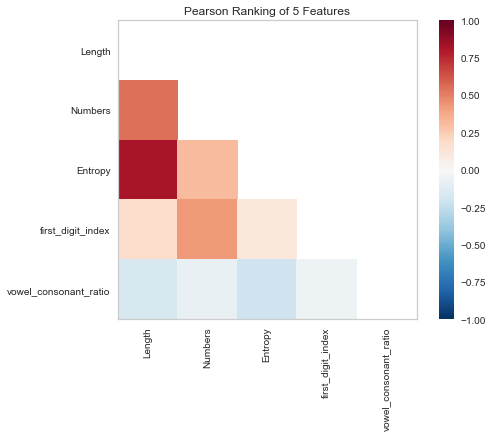

<AxesSubplot:title={'center':'Pearson Ranking of 5 Features'}>

In [39]:
#  to see correlation among features using pearson algorithm, Rank2D from yellowbrick
visualizer = Rank2D (algorithms = 'pearson', features = feature_names)
visualizer.fit_transform(features)
visualizer.poof()

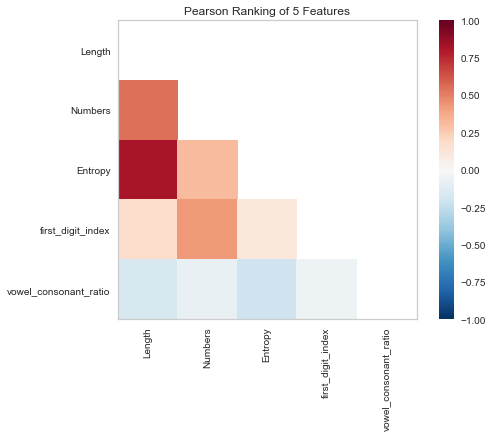

<AxesSubplot:title={'center':'Pearson Ranking of 5 Features'}>

In [41]:
#  to see correlation among features using covariance algorithm, Rank2D from yellowbrick
visualizer = Rank2D (algorithms = 'covariance', features = feature_names)
visualizer.fit_transform(features)
visualizer.poof()

/Users/hm/anaconda3/lib/python3.8/site-packages/yellowbrick/features/radviz.py:199: RuntimeWarning: invalid value encountered in true_divide
  xy = (s * row_).sum(axis=0) / row.sum()


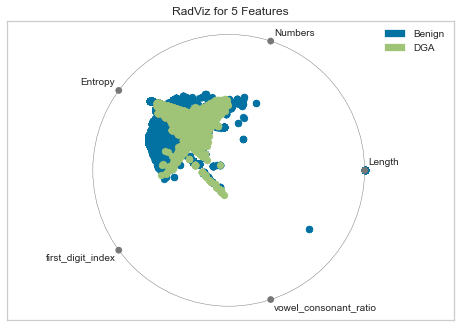

<AxesSubplot:title={'center':'RadViz for 5 Features'}>

In [42]:
# multivariate data visualization, RadViz from yellowbrick
X = domain_final[feature_names].to_numpy()
y = domain_final['IsDGA'].to_numpy()

radvisualizer = RadViz(classes = ['Benign', 'DGA'], features = feature_names )
radvisualizer.fit_transform(X, y)
radvisualizer.poof()

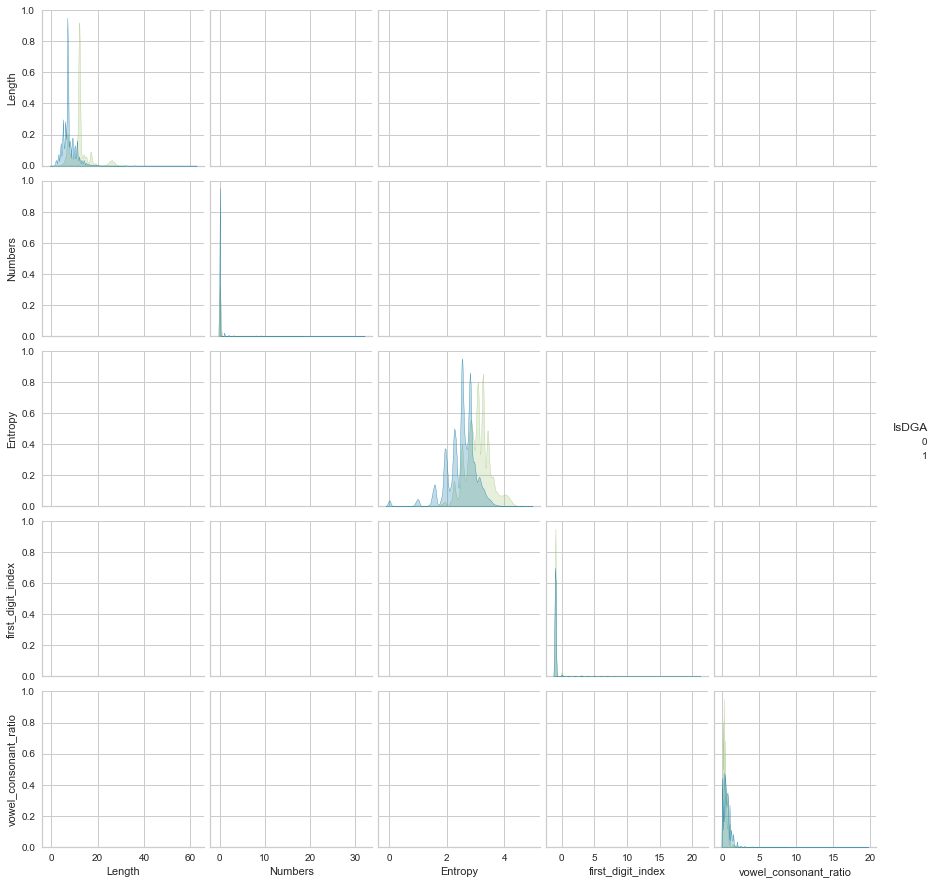

In [44]:
# pairplot, seaborn
g=sns.pairplot(domain_final, vars= feature_names, hue = 'IsDGA', kind='hex')

<AxesSubplot:xlabel='Entropy', ylabel='Count'>

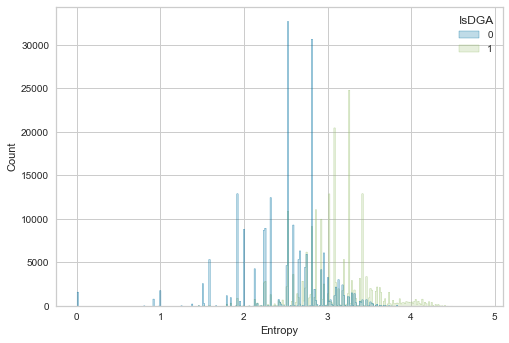

In [45]:
# histplot, seaborn
sns.histplot(domain_final, x="Entropy", hue="IsDGA", element="step")

<AxesSubplot:xlabel='Length', ylabel='Count'>

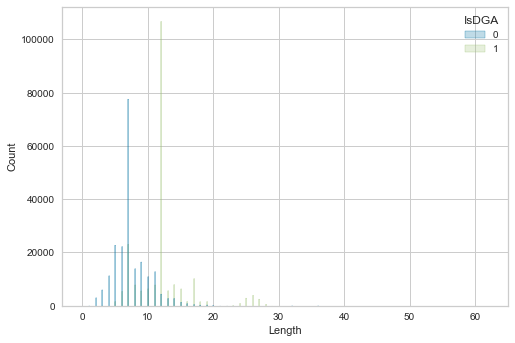

In [46]:
sns.histplot(domain_final, x="Length", hue="IsDGA", element="step")

<AxesSubplot:xlabel='first_digit_index', ylabel='Count'>

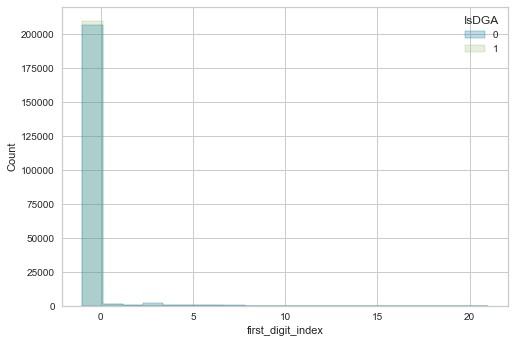

In [47]:
sns.histplot(domain_final, x="first_digit_index", hue="IsDGA", element="step")

<AxesSubplot:xlabel='vowel_consonant_ratio', ylabel='Count'>

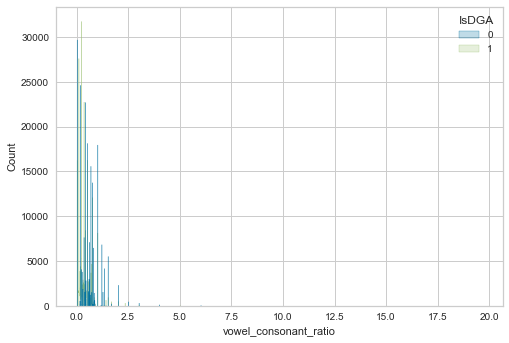

In [48]:
sns.histplot(domain_final, x="vowel_consonant_ratio", hue="IsDGA", element="step")